In [46]:
import numpy as np
import datetime

import torch
import torch.optim as optim
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

这段代码用于使用Python中的Matplotlib库创建数据可视化图表。以下是代码的解释：

1. `import matplotlib.pyplot as plt`：这行代码导入Matplotlib库，并将其命名为`plt`，这是一个常见的约定。通过这个库，您可以创建各种类型的图表和可视化。

2. `%matplotlib inline`：这是一个特殊的Jupyter Notebook或Jupyter Lab魔术命令，它确保在笔记本中创建的图表将直接显示在笔记本中，而不需要额外的命令。这样，您可以在笔记本中即时查看和交互式探索图表。

3. `plt.style.use('fivethirtyeight')`：这行代码应用了Matplotlib的样式（style），具体是名为'fivethirtyeight'的样式。这个样式模仿了常见于FiveThirtyEight网站上的图表风格。FiveThirtyEight以其数据新闻和可视化而闻名，这个样式可以使您的图表外观与其相似。

一旦运行了这些代码，您可以使用Matplotlib的函数来创建和显示图表。在上面的回答中，我提供了一个简单的示例，演示了如何创建和显示一个基本的线性图表。您可以使用Matplotlib的不同函数和功能来进一步修改和自定义图表，以满足您的特定可视化需求。

In [47]:
class StepByStep(object):
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model.to(self.device)

        self.train_loader = None
        self.val_loader = None
        self.writer = None

        self.losses = []
        self.val_losses = []
        self.total_epochs = 0

        self.train_step = self._make_train_step()
        self.val_step = self._make_val_step()

    def to(self, device):
        self.device = device
        self.model.to(self.device)

    def set_loaders(self, train_loader, val_loader = None):
        self.train_loader = train_loader
        self.val_loader = val_loader

    def set_tensorboard(self, name, folder = 'runs'):
        suffix = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
        self.writer = SummaryWriter('{}/{}_{}'.format(
            folder, name, suffix,
        ))

    def set_seed(self, seed = 42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.manual_seed(seed)
        np.random.seed(seed)

    '''
    torch.backends.cudnn.deterministic = True: 这一行设置了 PyTorch 的 CuDNN 后端，使其在使用GPU时具有确定性。这意味着在相同种子下，CuDNN 将生成相同的随机结果，确保了 GPU 计算的确定性。

    torch.backends.cudnn.benchmark = False: 这一行关闭了 CuDNN 的性能优化模式，该模式通常可以提高训练速度，但不保证结果的确定性。通过将其设置为 False，确保了结果的一致性，尤其是当使用不同的硬件或硬件配置时。
    '''

    def train(self, n_epochs, seed = 42):
        self.set_seed(seed)

        for epoch in range(n_epochs):
            self.total_epochs += 1

            loss = self._mini_batch(validation = False)
            self.losses.append(loss)

            with torch.no_grad():
                val_loss = self._mini_batch(validation = True)
                self.val_losses.append(val_loss)

            if self.writer:
                scalars = {'training' : loss}
                if val_loss is not None:
                    scalars.update({'validation' : val_loss})

                self.writer.add_scalars(main_tag = 'loss',
                                        tag_scalar_dict = scalars,
                                        global_step = epoch)
        if self.writer:
            self.writer.flush()

    def save_checkpoint(self, filename):
        checkpoint = {
            'epoch' : self.total_epochs,
            'model_state_dict' : self.model.state_dict(),
            'optimizer_state_dict' : self.optimizer.state_dict(),
            'loss' : self.losses,
            'val_loss' : self.val_losses,
        }
        torch.save(checkpoint, filename)

    def load_checkpoint(self, filename):
        checkpoint = torch.load(filename)

        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        self.total_epochs = checkpoint['epoch']
        self.losses = checkpoint['loss']
        self.val_losses = checkpoint['val_loss']

        self.model.train()

    def predict(self, x):
        self.model.eval()

        x_tensor = torch.as_tensor(x).float()
        y_hat_tensor = self.model(x_tensor.to(self.device))

        self.model.train()

        return y_hat_tensor.detach().cpu().numpy()

    def plot_losses(self):
        fig = plt.figure(figsize = (10, 4))
        plt.plot(self.losses, label = 'Training Loss', c = 'b')
        if self.val_loader:
            plt.plot(self.val_losses, label = 'Validation Loss', c = 'r')
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()

        return fig

    def add_graph(self):
        if self.train_loader and self.writer:

            x_dummy, y_dummy = next(iter(self.train_loader))
            self.writer.add_graph(self.model, x_dummy.to(self.device))


    def _make_train_step(self):
        def perform_train_step(x, y):
            self.model.train()

            yhat = self.model(x)
            loss = self.loss_fn(yhat, y)
            loss.backward()

            self.optimizer.step()
            self.optimizer.zero_grad()

            return loss.item()

        return perform_train_step

    def _make_val_step(self):
        def perform_val_step(x, y):
            self.model.eval()

            yhat = self.model(x)
            loss = self.loss_fn(yhat, y)

            return loss.item()

        return perform_val_step

    def _mini_batch(self, validation = False):
        if validation:
            data_loader = self.val_loader
            step = self.val_step
        else:
            data_loader = self.train_loader
            step = self.train_step

        if data_loader is None:
            return None

        mini_batch_losses = []
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)

            mini_batch_loss = step(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)

        loss = np.mean(mini_batch_losses)

        return loss

In [48]:
torch.manual_seed(13)

x = np.sort(np.random.rand(64, 1), axis = 0)
y = np.sort(np.random.rand(64, 1), axis = 0)

x_tensor = torch.as_tensor(x).float()
y_tensor = torch.as_tensor(y).float()

dataset = TensorDataset(x_tensor, y_tensor)

ratio = 0.8
n_total = len(dataset)
n_train = int(n_total * ratio)
n_val = n_total - n_train

trian_data, val_data = random_split(dataset, [n_train, n_val])

train_loader = DataLoader(
    dataset = trian_data,
    batch_size = 16,
    shuffle = True,
)

val_loader = DataLoader(
    dataset = val_data,
    batch_size = 16,
)

In [49]:
lr = 0.1

torch.manual_seed(42)

model = nn.Sequential(
    nn.Linear(1, 1),
)

optimizer = optim.SGD(model.parameters(), lr = lr)

loss_fn = nn.MSELoss(reduction = 'mean')

In [50]:
sbs = StepByStep(model, loss_fn, optimizer)
sbs.set_loaders(train_loader, val_loader)
sbs.set_tensorboard('classy')

In [51]:
sbs.train(n_epochs = 200)

In [52]:
print(model.state_dict())
print(sbs.model == model)

OrderedDict([('0.weight', tensor([[0.9745]])), ('0.bias', tensor([0.0359]))])
True


这里可以看出来sbs实例中的model和我们在main中的model变量是同一个玩意

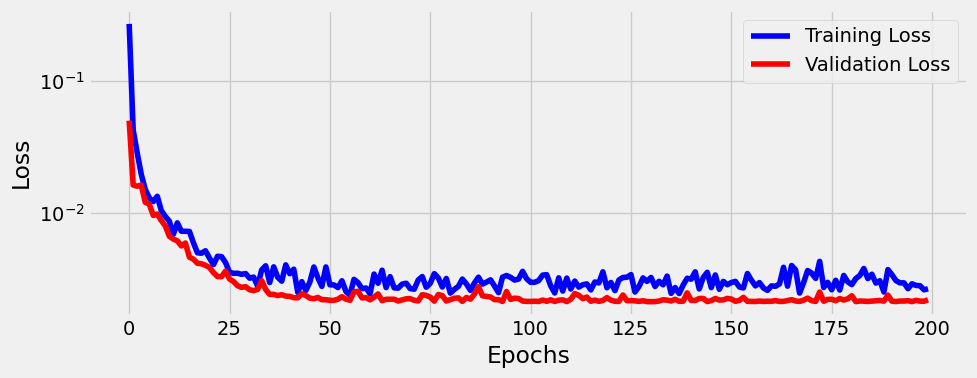

In [53]:
fig = sbs.plot_losses()

In [54]:
new_data = np.array([.5, .3, .7]).reshape(-1, 1)

predictions = sbs.predict(new_data)
predictions

array([[0.52312845],
       [0.32822436],
       [0.7180325 ]], dtype=float32)

In [55]:
sbs.save_checkpoint('model_checkpoint.pth')